In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [82]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

from tools_fast import make_track, ols_regression, make_ER, lasso_regression, lasso_regression_ic, ridge_regression, \
    kalman_filter, selective_kalman_filter, replication_stats, ml_kalman_filter, \
    ml_kalman_filter2, ml_selective_kalman_filter
from clustering import cluster, cluster_net
from hc_graph import hc_stock, hc_piechart, hc_spiderweb

In [5]:
fund_name = 'HFRXM'
pd.read_csv(r"financial_data/hfrx_index_names.csv", index_col=0)

,Full Name
Name,
HFRXAR,HFRX Absolute Return Index
HFRXDS,HFRX ED: Distressed Restructuring Index
HFRXMA,HFRX ED: Merger Arbitrage Index
HFRXSS,HFRX ED: Special Situations Index
HFRXEMN,HFRX EH: Equity Market Neutral Index
HFRXEHG,HFRX EH: Fundamental Growth Index
HFRXEHV,HFRX EH: Fundamental Value Index
HFRXEMC,HFRX Emerging Markets Composite Index
HFRXEWC,HFRX Equal Weighted Strategies CHF Index


### Financial data loads and cleaning

In [6]:
# US rate
US_rate = pd.read_csv(r"financial_data/USD_rates.csv", index_col=0, parse_dates=True, dayfirst=True)['3M']

# HFRX
hfrx_all = pd.read_csv(r"financial_data/hfrx_daily_index_data.csv", index_col=0, parse_dates=True, dayfirst=True).ffill()
hfrx = make_ER(hfrx_all[[fund_name]].dropna(), US_rate)

# BNP

bnp = pd.read_csv(r"financial_data/bnp_data.csv", index_col=0, parse_dates=True, dayfirst=True) #[["BNPIFEU","BNPIFUS",
                 #"BNPIFJP","BNPIFCN","BNPIFFR","BNPIFGE","BNPIFGB","BNPIFCH","BNPIFKR","BNPIFUSC","BNPIFBR",
                 #"BNPIFAU","BNPIFHK","BNPIFTW","BNPIFSG","BNPIFIT","BNPIFSP","BNPIFSW","BNPIFNE","BNPIFRU","BNPIFEM"]]

risk_premia = pd.read_pickle("financial_data/risk_premia_ER_FX_USD.pkl") #[["BNPICCE3","BNPIVMRU","BNPIAIRT","BNPIAIRU",
                  #"BNPIEC03","BNPIPLEE","BNPIPMEE","BNPIPQEE","BNPIPVEE","BNPILUEE","BNPIPMUH","BNPIPQUH",
                  #"BNPIPVUH","BNPIAIRG","BNPIAIRJ","BNPIAIRE"]]

In [7]:
df_info = pd.read_csv(r"financial_data/bnp_info.csv", index_col=0)
df_info.head()

,Asset Class,Style
Ticker,,
BNPIDRXA,Commodity,Carry
BNPIF3AX,Commodity,Carry
BNPIF3XM,Commodity,Momentum
BPFXSTGU,FX,Value
BNPICCE3,Equity,Carry


In [8]:
prices_all = bnp.join(risk_premia,how="inner").ffill().join(hfrx,how="inner")
prices_all.head()

,BNPIFEU,BNPIFUS,BNPIFJP,BNPIFCN,BNPIFFR,BNPIFGE,BNPIFGB,BNPIFCH,BNPIFKR,BNPIFUSC,...,BNPIPQEE,BNPIPVEE,BNPILUEE,BNPIPMUH,BNPIPQUH,BNPIPVUH,BNPIMDEA,BNPIAIFH,BNPICVXA,HFRXM
2007-01-03,251.659037,221.446381,123.569027,122.453216,213.419777,187.351929,143.396494,295.276204,289.6684,214.633123,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.125824
2007-01-04,250.891929,221.752767,124.485468,116.840530,212.022884,186.812785,142.625314,294.978808,285.5191,215.297053,...,0.996090,0.995580,0.997660,1.001242,1.000243,0.996902,1.000146,1.0,1.0,1.120778
2007-01-05,247.941926,220.296431,122.435019,116.354951,210.202422,184.800752,141.220705,294.559578,283.5307,211.436575,...,1.000518,1.000001,0.996420,0.999333,0.999586,0.998485,0.989704,1.0,1.0,1.107019
2007-01-08,247.619806,220.849207,122.435019,114.489675,209.896589,184.914022,140.466947,292.889470,280.1748,211.660237,...,1.005248,1.002365,0.997761,1.000212,0.998146,0.996573,0.988449,1.0,1.0,1.105232
2007-01-09,247.980535,220.738811,123.630465,112.996176,210.556213,185.164783,140.518570,293.917702,281.4930,211.994064,...,1.005052,1.002498,0.999367,1.001821,0.995801,0.994901,0.988940,1.0,1.0,1.105753


In [9]:
returns_all = prices_all.pct_change().iloc[1:]
hrfx_returns = returns_all[[fund_name]]
returns_all = returns_all.drop(fund_name, axis=1)
returns_fut = returns_all[bnp.columns]
returns_risk_premia = returns_all[risk_premia.columns]
prices_all = prices_all.drop(fund_name, axis=1)
prices_all = prices_all.bfill()
prices_futur = prices_all[bnp.columns]
prices_risk_premia = prices_all[risk_premia.columns]

## Estimation of the exposures

In [48]:
size = 126
freq = 5

In [49]:
%%time
nu = 1.0
df_weight_kalman = kalman_filter(hrfx_returns, returns_all,freq, sigma_weight=1. , sigma_return=nu)

prices_for_track_kalman = prices_all.loc[df_weight_kalman.index[0]:]

Wall time: 293 ms


### Volatility adjustment

In [64]:
tau = 0.1
tc = 0.0005
nu = 1.0
lag = 3

In [65]:
%%time

df_weight_kalman_aic_voladj = selective_kalman_filter(hrfx_returns, returns_all,sample_length=size, frequency=freq,\
                                          nu=nu, criterion='aic', vol_target=True)
df_weight_kalman_bic_voladj = selective_kalman_filter(hrfx_returns, returns_all,sample_length=size, frequency=freq,\
                                          nu=nu, criterion='bic', vol_target=True)
df_weight_kalman_voladj = kalman_filter(hrfx_returns, returns_all,freq, sigma_weight=1. , sigma_return=nu, vol_target=True)
df_weight_ml_kalman_voladj, _ = ml_kalman_filter(hrfx_returns, returns_all,freq, tau=tau, vol_target=True)

prices_for_track = prices_all.loc[df_weight_kalman_aic_voladj.index[0]:]

replication_kalman_aic_voladj = make_track(prices_for_track, df_weight_kalman_aic_voladj, tc=tc, lag=lag)
df_res_voladj = hfrx.loc[replication_kalman_aic_voladj.index]
df_res_voladj["Kalman AIC all"] = replication_kalman_aic_voladj

replication_kalman_bic_voladj = make_track(prices_for_track, df_weight_kalman_bic_voladj, tc=tc, lag=lag)
df_res_voladj["Kalman BIC all"] = replication_kalman_bic_voladj

prices_for_track = prices_all.loc[df_weight_kalman_voladj.index[0]:]

replication_kalman_voladj = make_track(prices_for_track, df_weight_kalman_voladj, tc=tc, lag=lag)
df_res_voladj["Kalman all"] = replication_kalman_voladj

Wall time: 1min 25s


In [66]:
%%time
freq_ml = 20
df_weight_ml_kalman_bic = ml_selective_kalman_filter(hrfx_returns, returns_all,sample_length=size, frequency=freq_ml,
                                                     tau=tau, criterion='bic',vol_target=True)

prices_for_track_ml_kalman_bic = prices_all.loc[df_weight_ml_kalman_bic.index[0]:]

replication_ml_kalman_bic_voladj = make_track(prices_for_track_ml_kalman_bic, df_weight_ml_kalman_bic, tc=tc, lag=lag)
df_res_voladj["Kalman ML BIC all"] = replication_ml_kalman_bic_voladj

df_weight_ml_kalman_aic = ml_selective_kalman_filter(hrfx_returns, returns_all,sample_length=size, frequency=freq_ml,
                                                     tau=tau, criterion='aic',vol_target=True)

prices_for_track_ml_kalman_aic = prices_all.loc[df_weight_ml_kalman_aic.index[0]:]

replication_ml_kalman_aic_voladj = make_track(prices_for_track_ml_kalman_aic, df_weight_ml_kalman_aic, tc=tc, lag=lag)
df_res_voladj["Kalman ML AIC all"] = replication_ml_kalman_aic_voladj


Wall time: 27.8 s


In [67]:
%%time
##fut

df_weight_kalman_aic_voladj_fut = selective_kalman_filter(hrfx_returns, returns_fut,sample_length=size, frequency=freq,\
                                          nu=nu, criterion='aic', vol_target=True)

df_weight_kalman_bic_voladj_fut = selective_kalman_filter(hrfx_returns, returns_fut,sample_length=size, frequency=freq,\
                                          nu=nu, criterion='bic', vol_target=True)

df_weight_kalman_voladj_fut = kalman_filter(hrfx_returns, returns_fut,freq, sigma_weight=1. , sigma_return=nu, vol_target=True)
df_weight_ml_kalman_voladj_fut, _ = ml_kalman_filter(hrfx_returns, returns_fut,freq, tau=tau, vol_target=True)

prices_for_track = prices_futur.loc[df_weight_kalman_aic_voladj_fut.index[0]:]

replication_kalman_aic_voladj_fut = make_track(prices_for_track, df_weight_kalman_aic_voladj_fut, tc=tc, lag=lag)
df_res_voladj_fut = hfrx.loc[replication_kalman_aic_voladj_fut.index]
df_res_voladj_fut["Kalman AIC futures"] = replication_kalman_aic_voladj_fut

replication_kalman_bic_voladj_fut = make_track(prices_for_track, df_weight_kalman_bic_voladj_fut, tc=tc, lag=lag)
df_res_voladj_fut["Kalman BIC futures"] = replication_kalman_bic_voladj_fut

prices_for_track = prices_futur.loc[df_weight_kalman_voladj_fut.index[0]:]

replication_kalman_voladj_fut = make_track(prices_for_track, df_weight_kalman_voladj_fut, tc=tc, lag=lag)
df_res_voladj_fut["Kalman futures"] = replication_kalman_voladj_fut


Wall time: 51 s


In [68]:
%%time

freq_ml = 20
df_weight_ml_kalman_bic = ml_selective_kalman_filter(hrfx_returns, returns_fut,sample_length=size, frequency=freq_ml,
                                                     tau=tau, criterion='bic',vol_target=True)

prices_for_track_ml_kalman_bic = prices_futur.loc[df_weight_ml_kalman_bic.index[0]:]

replication_ml_kalman_bic_voladj_fut = make_track(prices_for_track_ml_kalman_bic, df_weight_ml_kalman_bic, tc=tc, lag=lag)
df_res_voladj_fut["Kalman ML BIC fut"] = replication_ml_kalman_bic_voladj_fut

df_weight_ml_kalman_aic = ml_selective_kalman_filter(hrfx_returns, returns_fut,sample_length=size, frequency=freq_ml,
                                                     tau=tau, criterion='aic',vol_target=True)

prices_for_track_ml_kalman_aic = prices_futur.loc[df_weight_ml_kalman_aic.index[0]:]

replication_ml_kalman_aic_voladj_fut = make_track(prices_for_track_ml_kalman_aic, df_weight_ml_kalman_aic, tc=tc, lag=lag)
df_res_voladj_fut["Kalman ML AIC fut"] = replication_ml_kalman_aic_voladj_fut


Wall time: 18.9 s


In [69]:
%%time
## Risk Premia

df_weight_kalman_aic_voladj_risk_premia = selective_kalman_filter(hrfx_returns, returns_risk_premia,sample_length=size, frequency=freq,\
                                          nu=nu, criterion='aic', vol_target=True)
df_weight_kalman_bic_voladj_risk_premia = selective_kalman_filter(hrfx_returns, returns_risk_premia,sample_length=size, frequency=freq,\
                                          nu=nu, criterion='bic', vol_target=True)
df_weight_kalman_voladj_risk_premia = kalman_filter(hrfx_returns, returns_risk_premia,freq, sigma_weight=1. , sigma_return=nu, vol_target=True)
df_weight_ml_kalman_voladj_risk_premia, _ = ml_kalman_filter(hrfx_returns, returns_risk_premia,freq, tau=tau, vol_target=True)

prices_for_track = prices_risk_premia.loc[df_weight_kalman_aic_voladj_risk_premia.index[0]:]

replication_kalman_aic_voladj_risk_premia = make_track(prices_for_track, df_weight_kalman_aic_voladj_risk_premia, tc=tc, lag=lag)
df_res_voladj_risk_premia = hfrx.loc[replication_kalman_aic_voladj_risk_premia.index]
df_res_voladj_risk_premia["Kalman AIC Risk Premia"] = replication_kalman_aic_voladj_risk_premia

replication_kalman_bic_voladj_risk_premia = make_track(prices_for_track, df_weight_kalman_bic_voladj_risk_premia, tc=tc, lag=lag)
df_res_voladj_risk_premia["Kalman BIC Risk Premia"] = replication_kalman_bic_voladj_risk_premia

prices_for_track = prices_risk_premia.loc[df_weight_kalman_voladj_risk_premia.index[0]:]

replication_kalman_voladj_risk_premia = make_track(prices_for_track, df_weight_kalman_voladj_risk_premia, tc=tc, lag=lag)
df_res_voladj_risk_premia["Kalman Risk Premia"] = replication_kalman_voladj_risk_premia

Wall time: 11.2 s


In [70]:
%%time

freq_ml = 20
df_weight_ml_kalman_bic = ml_selective_kalman_filter(hrfx_returns, returns_risk_premia,sample_length=size, frequency=freq_ml,
                                                     tau=tau, criterion='bic',vol_target=True)

prices_for_track_ml_kalman_bic = prices_risk_premia.loc[df_weight_ml_kalman_bic.index[0]:]

replication_ml_kalman_bic_voladj_risk_premia = make_track(prices_for_track_ml_kalman_bic, df_weight_ml_kalman_bic, tc=tc, lag=lag)
df_res_voladj_risk_premia["Kalman ML BIC risk_premia"] = replication_ml_kalman_bic_voladj_risk_premia

df_weight_ml_kalman_aic = ml_selective_kalman_filter(hrfx_returns, returns_risk_premia,sample_length=size, frequency=freq_ml,
                                                     tau=tau, criterion='aic',vol_target=True)

prices_for_track_ml_kalman_aic = prices_risk_premia.loc[df_weight_ml_kalman_aic.index[0]:]

replication_ml_kalman_aic_voladj_risk_premia = make_track(prices_for_track_ml_kalman_aic, df_weight_ml_kalman_aic, tc=tc, lag=lag)
df_res_voladj_risk_premia["Kalman ML AIC risk_premia"] = replication_ml_kalman_aic_voladj_risk_premia


Wall time: 7.43 s


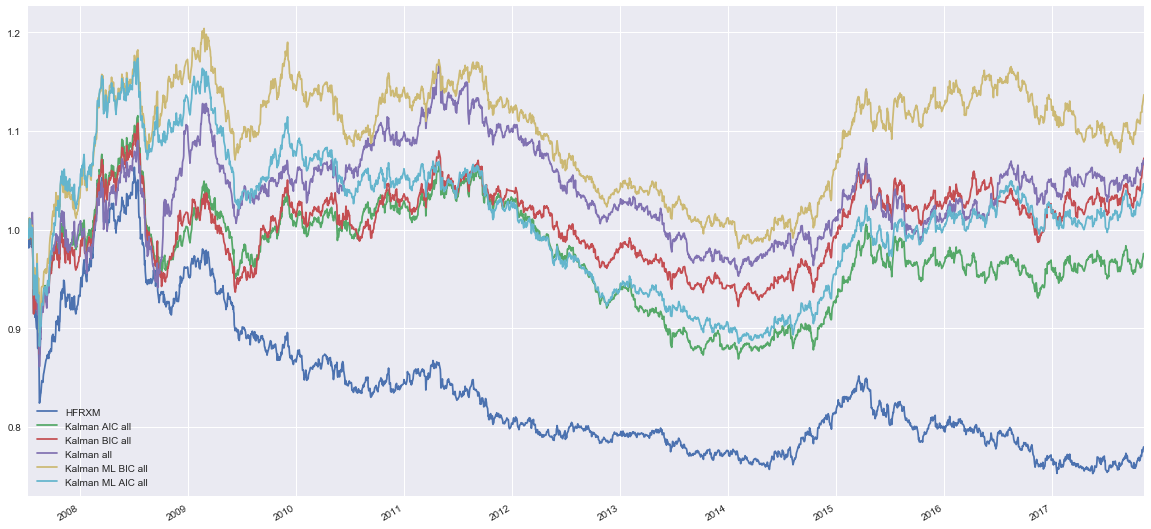

In [71]:
df_res_voladj = df_res_voladj.bfill()
df_res_voladj = (df_res_voladj / df_res_voladj.iloc[0])
df_res_volperfadj = df_res_voladj[[fund_name]].copy()
temp = df_res_voladj.drop(fund_name, axis=1)
df_res_volperfadj[temp.columns]= make_ER(temp, 2 + 0 * US_rate)
df_res_volperfadj.plot(figsize=(20,10))

c:\users\maxence\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: pd.rolling_corr is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=126).corr(other=<Series>)
  """Entry point for launching an IPython kernel.
c:\users\maxence\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: pd.rolling_corr is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=126).corr(other=<Series>)
  
c:\users\maxence\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: pd.rolling_corr is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=126).corr(other=<Series>)
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\maxence\appdata\local\programs\python\python36-32\lib\site-packages\ip

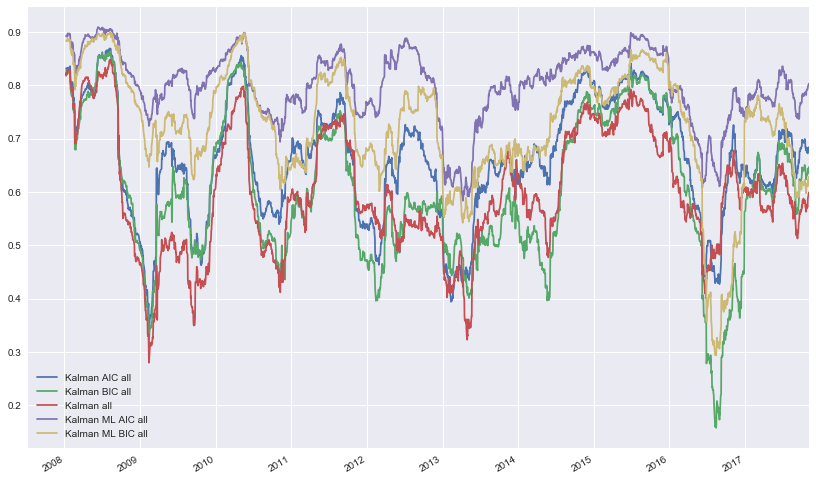

In [103]:
ax = pd.rolling_corr(df_res_voladj[fund_name].pct_change() ,df_res_voladj["Kalman AIC all"].pct_change(), 126).plot(figsize =(14,9), label='Kalman AIC all', legend=True)
pd.rolling_corr(df_res_voladj[fund_name].pct_change() ,df_res_voladj["Kalman BIC all"].pct_change(), 126).plot(ax=ax,label='Kalman BIC all', legend=True)
pd.rolling_corr(df_res_voladj[fund_name].pct_change() ,df_res_voladj["Kalman all"].pct_change(), 126).plot(ax=ax,label='Kalman all', legend=True)
pd.rolling_corr(df_res_voladj[fund_name].pct_change() ,df_res_voladj["Kalman ML AIC all"].pct_change(), 126).plot(ax=ax,label='Kalman ML AIC all', legend=True)
pd.rolling_corr(df_res_voladj[fund_name].pct_change() ,df_res_voladj["Kalman ML BIC all"].pct_change(), 126).plot(ax=ax,label='Kalman ML BIC all', legend=True)

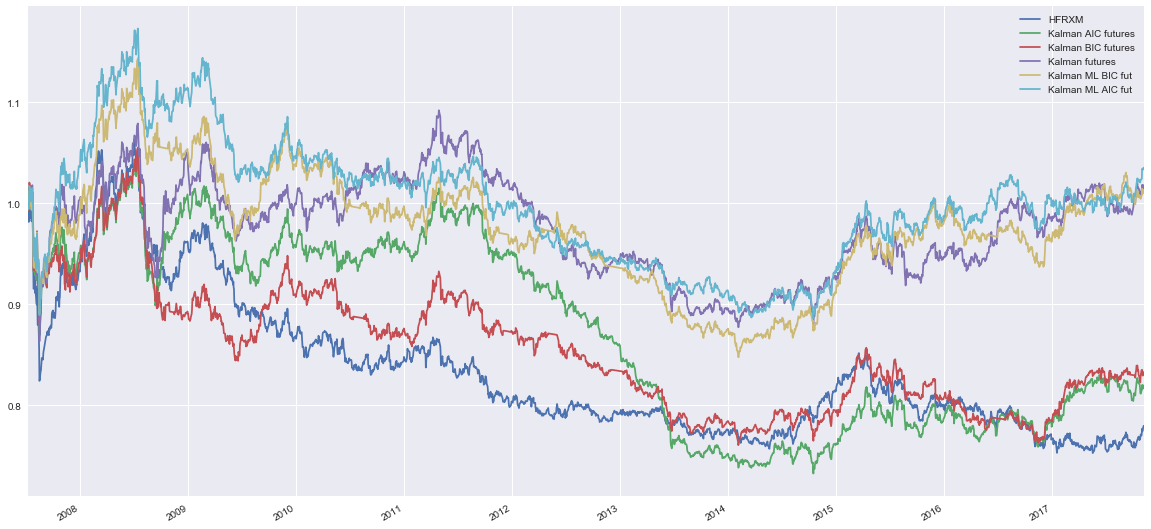

In [73]:
df_res_voladj_fut = df_res_voladj_fut.bfill()
df_res_voladj_fut = (df_res_voladj_fut / df_res_voladj_fut.iloc[0])
df_res_volperfadj_fut = df_res_voladj_fut[[fund_name]].copy()
temp = df_res_voladj_fut.drop(fund_name, axis=1)
df_res_volperfadj_fut[temp.columns]= make_ER(temp, 2 + 0 * US_rate)
df_res_volperfadj_fut.plot(figsize=(20,10))

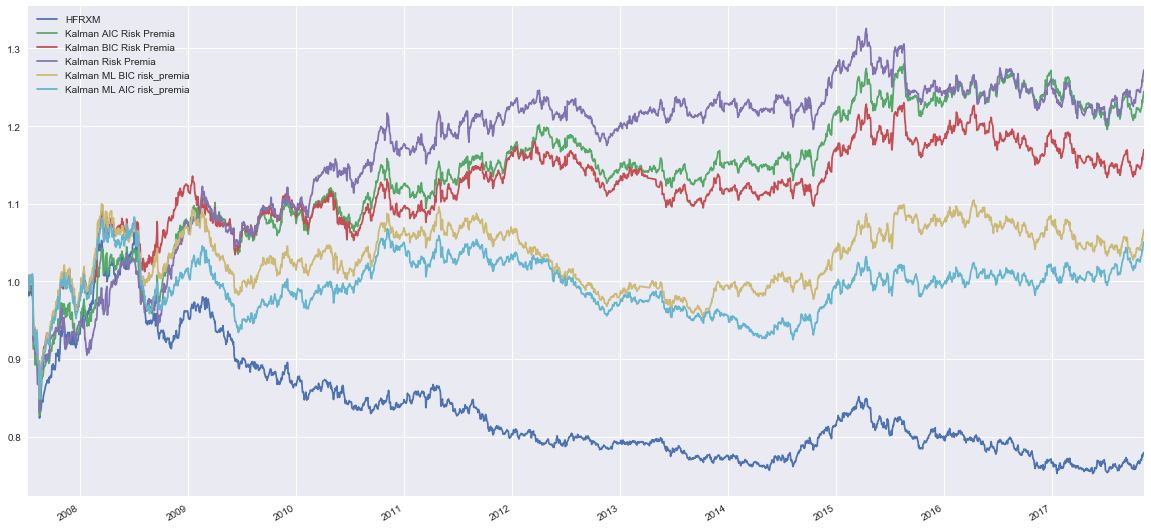

In [74]:
df_res_voladj_risk_premia = df_res_voladj_risk_premia.bfill()
df_res_voladj_risk_premia = (df_res_voladj_risk_premia / df_res_voladj_risk_premia.iloc[0])
df_res_volperfadj_risk_premia = df_res_voladj_risk_premia[[fund_name]].copy()
temp = df_res_voladj_risk_premia.drop(fund_name, axis=1)
df_res_volperfadj_risk_premia[temp.columns]= make_ER(temp, 2 + 0 * US_rate)
df_res_volperfadj_risk_premia.plot(figsize=(20,10))

## Statistics on replication

In [79]:
df_stat_vol = replication_stats(df_res_voladj, fund_name=fund_name)
df_stat_vol

,Tracking error,R-squared,Sharpe ratio,Annual Return,Correlation,Kendall tau
HFRXM,0.000000,1.000000,-0.334755,-0.023715,1.000000,1.000000
Kalman AIC all,0.006491,0.487530,0.308740,0.017974,0.740749,0.474064
Kalman BIC all,0.006647,0.462659,0.439432,0.027067,0.733373,0.457830
Kalman all,0.007334,0.345768,0.408354,0.027097,0.707442,0.480009
Kalman ML BIC all,0.005709,0.603624,0.539685,0.032844,0.797132,0.545489
Kalman ML AIC all,0.005015,0.694080,0.415843,0.024858,0.844220,0.598830


In [80]:
df_stat_vol_fut = replication_stats(df_res_voladj_fut, fund_name=fund_name)
df_stat_vol_fut

,Tracking error,R-squared,Sharpe ratio,Annual Return,Correlation,Kendall tau
HFRXM,0.000000,1.000000,-0.334755,-0.023715,1.000000,1.000000
Kalman AIC futures,0.007268,0.357438,0.046889,0.000852,0.694101,0.435993
Kalman BIC futures,0.007429,0.328795,0.070473,0.002451,0.663777,0.365770
Kalman futures,0.007898,0.241308,0.338781,0.022127,0.663396,0.420102
Kalman ML BIC fut,0.006116,0.545085,0.378524,0.021588,0.760236,0.494587
Kalman ML AIC fut,0.005224,0.668085,0.402058,0.023748,0.829588,0.595437


In [81]:
df_stat_vol_risk_premia = replication_stats(df_res_voladj_risk_premia, fund_name=fund_name)
df_stat_vol_risk_premia

,Tracking error,R-squared,Sharpe ratio,Annual Return,Correlation,Kendall tau
HFRXM,0.000000,1.000000,-0.334755,-0.023715,1.000000,1.000000
Kalman AIC Risk Premia,0.006869,0.426124,0.633750,0.041939,0.728162,0.466988
Kalman BIC Risk Premia,0.007155,0.377276,0.549785,0.035762,0.702861,0.453329
Kalman Risk Premia,0.007697,0.279428,0.649125,0.044192,0.669418,0.443621
Kalman ML BIC risk_premia,0.006075,0.551141,0.437032,0.026585,0.774295,0.500228
Kalman ML AIC risk_premia,0.005473,0.635714,0.413724,0.025183,0.818003,0.547586


In [112]:
df_vol_contrib_kalman_voladj = (prices_all.reindex(df_weight_kalman_voladj.index).pct_change()*df_weight_kalman_voladj).std()
df_vol_contrib_kalman_voladj = df_vol_contrib_kalman_voladj/df_vol_contrib_kalman_voladj.sum()

df_vol_contrib_kalman_aic_voladj = (prices_all.reindex(df_weight_kalman_aic_voladj.index).pct_change()*df_weight_kalman_aic_voladj).std()
df_vol_contrib_kalman_aic_voladj = df_vol_contrib_kalman_aic_voladj/df_vol_contrib_kalman_aic_voladj.sum()

df_vol_contrib_ml_kalman_aic_voladj = (prices_all.reindex(df_weight_ml_kalman_aic.index).pct_change()*df_weight_ml_kalman_aic).std()
df_vol_contrib_ml_kalman_aic_voladj = df_vol_contrib_ml_kalman_aic_voladj/df_vol_contrib_ml_kalman_aic_voladj.sum()

In [113]:
df_vol_contrib = pd.DataFrame()
df_vol_contrib["Kalman"] = df_vol_contrib_kalman_voladj
df_vol_contrib["Kalman AIC"] = df_vol_contrib_kalman_bic_voladj
df_vol_contrib["Kalman AIC ML"] = df_vol_contrib_kalman_aic_voladj
df_vol_contrib = df_vol_contrib.join(df_info).reset_index()

In [114]:
df_vol_contrib_asset_class = df_vol_contrib.drop(["Style"],axis=1).groupby(["Asset Class","index"]).sum()
df_vol_contrib_style = df_vol_contrib.drop(["Asset Class"],axis=1).groupby(["Style","index"]).sum()

In [116]:
g = hc_piechart(df_vol_contrib_style[["Kalman AIC ML"]], title="Vol contribution by Style in Kalman BIC")
g.plot()